# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# Thanks!
# hello
print('hello world')

hello world

### Run the next cell to create your directory in dbfs
You do not need to understand this scala snippet. It simply dynamically fetches your user directory name so that any files you write can be saved in your own directory.

In [0]:
# RUN THIS CELL AS IS
# This code snippet reads the user directory name, and stores is in a python variable.
# Next, it creates a folder inside your home folder, which you will use for files which you save inside this notebook.
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
hw5_path = userhome + "/HW5/" 
hw5_path_open = '/dbfs' + hw5_path.split(':')[-1] # for use with python open()
dbutils.fs.mkdirs(hw5_path)

dbfs:/user/sonyasonya345@berkeley.edu
Out[5]: True

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[6]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/5d74113d-bae1-4f39-81a1-b158b698ea13/,5d74113d-bae1-4f39-81a1-b158b698ea13/,0
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
# RUN THIS CELL AS IS - A test to make sure your directory is working as expected.
# You should see a result like:
# dbfs:/user/youremail@ischool.berkeley.edu/HW5/test.txt
dbutils.fs.put(hw5_path+'test.txt',"hello world",True)
display(dbutils.fs.ls(hw5_path))


Wrote 11 bytes.

path,name,size
dbfs:/user/sonyasonya345@berkeley.edu/HW5/test.txt,test.txt,11


In [0]:
sc = spark.sparkContext
spark

Out[9]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.99.235.125:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:

> __1a)__ Give an example of a dataset that would be appropriate to represent as a graph. 
> What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? 
> What would the average "in-degree" of a node mean in the context of your example?  
> * For example, the relationship of twitter users is would be appropriate to represent as a graph. 
> * In the twitter users example, nodes are users, and their relationship is the edges. 
> * In the twitter example, the edge is directed. The reason is that in twitter, userA can follow userB, but userB does not neccesarily follow userA. 
> * Say UserA follows userA, then the edge start at UserA and has the arrow pointing toward userB. And userA is a follower of UserB in this case. 
> * Ingree represent the number of incoming neighbors. 
> * The averege "in-degree" of a node is the average number of followers a user has. 


> __1b)__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? \
> * It is challenging for map-reduce. The reason is a node could have many neighbors, and thus the results of a mapper might need to arrive a different reducers. 
> * Say if we have 10 mappers, and each mapper produce 10 results, and each of theses 10 results need to arrive a different reducers.
> * With 10 mappers, we might ahve 100 results that need to do large amount of shuffling and combing before we can do the next step of computation. 
> * And that shuffling and combining is expensive as data traffice is costly. 

> * In addition, for graph computation, we have to do matrix multiplication. And if the matrix is very big, and matrix mulitplication is expensive, a sinlge machine might not be able to fit the all of that. 


> __c)__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?
> * Dijstka is the algorithm's goal is the find the shortest path from starting position to the destination. 
> * The approach Dijska take is:
>> * The approach is we always pick the next node that is unvisited and has the shortest distance from the current node (with the info we have up until this point). 
>> * When we are at the next node, we again update the distance of all of its neighboring nodes. 
>> * Then again, we pick the next unvisited node with the shortest distance, and go there. 
>> * We do so until we reach our destination node. 

> * When we pick which node to go next, we need to know the latest information of all the neighboring node. And the next node will update the information of neighbor nodes. And that update decide which node we go next again.
> * In Dijkstra, the order of node visit matter! Becaseu that ensures that we use the least cost to find the shortest path.
> * Thus in this approach, we can ONLY VISIT one node at a time. That means we cannot compute the results for several nodes at the same time. 


>__d)__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?
> * In breadth-first-search, it is okay to visit the neighbors of current node at the SAME TIME, which mean we can visit the neighbor of the current node in parallel.
> * If visit a node has some cost, then breath-first-search will not garantee that we utilized minimum cost or does not garantee that we can find the shortest path from the starting node to the destination node.
#

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ This is relatively dense, compared to a graph like the world-wide-web. Sparse graphs will have a much smaller adjacency list representation compared to their matrix representation, as the matrix has to have an entry even for non-existent edges.

> __b)__ The graph is directed. An adjacency matrix for an undirected graph will be symetric, while a directed graph's adjacency matrix will not.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

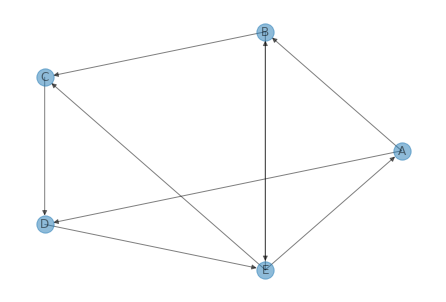

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for fr, to in graph['edges']:
      # pandas dataframes will select column first, then within the column, row 
      adj_matr[to][fr] = float(1.0)
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for node1, node2 in graph['edges']:
      adj_list[node1].append(node2)
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. 
Q: In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?
> The PageRank link analysis algorithm "measures" the relative importance of each page in the WebGraph


> __b)__ What is the "Markov Property" and what does it mean in the context of PageRank?
> * Markov processes provide a principled approach to calculating each page's PageRank.
> * PageRank is the steady-state probability distribution of the Markov process underlying the random-surfer navigation model.
> * With Markov: Stochasticity resolves dangling edges problem. 
> * Primitivity: Incorporates teleportation (Brin and Page)
> * With both stochasticity and primitivity: Guarantee convergence


> __c)__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?
> * This implies that the size of the transition matrix will be n x n matrix. # TODO: confirm.

> __d)__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]
> * right stochastic matrix is a non-negative real number square matrix, with each row summing to 1.
> * The sch


> __e)__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, 
until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. 

> Q: How many iterations does it take to converge? 
> * It takes 56 iterations to converge. # TODO: confirm

> Q: Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
> * Node E is the most central node (or highest ranking node). It is close to my intuition.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[19]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
def create_transition_matrix(adj_matrix):
    return adj_matrix.mul((1.0 / adj_matrix.sum(axis=1)), axis=0)
    
transition_matrix = create_transition_matrix(TOY_ADJ_MATR) # replace with your code
################ (END) YOUR CODE #################
print(transition_matrix)

A B C D E
A 0.000000 0.500000 0.000000 0.5 0.0
B 0.000000 0.000000 0.500000 0.0 0.5
C 0.000000 0.000000 0.000000 1.0 0.0
D 0.000000 0.000000 0.000000 0.0 1.0
E 0.333333 0.333333 0.333333 0.0 0.0

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    last_state = np.copy(state_vector)
    if verbose:
        print(f'\nStep[0] Initial state:')
        print(f'{state_vector}')
    i = 1
    trans_mat = tMatrix.to_numpy()
    while i <= nIter:
        # df.apply acts column-wise by default, but it can can also act row-wise by passing axis=1 as an argument to apply.
        # note: your position is [0, 0, 0, 0. 1.0] after 1st iteration b/c you will be at position E. 
        state_vector = trans_mat.transpose().dot(state_vector)

        if verbose:
            print(f'\nStep[{i}] state:')
            print(f'{state_vector}')
        if np.allclose(state_vector, last_state, rtol=1e-08, atol=1e-11):
            break
        
        last_state = np.copy(state_vector)
        i += 1
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step[0] Initial state:
[1. 0. 0. 0. 0.]

Step[1] state:
[0. 0.5 0. 0.5 0. ]

Step[2] state:
[0. 0. 0.25 0. 0.75]

Step[3] state:
[0.25 0.25 0.25 0.25 0. ]

Step[4] state:
[0. 0.125 0.125 0.375 0.375]

Step[5] state:
[0.125 0.125 0.1875 0.125 0.4375]

Step[6] state:
[0.14583333 0.20833333 0.20833333 0.25 0.1875 ]

Step[7] state:
[0.0625 0.13541667 0.16666667 0.28125 0.35416667]

Step[8] state:
[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]

Step[9] state:
[0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]

Step[10] state:
[0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 100, verbose = True)

Step[0] Initial state:
[1. 0. 0. 0. 0.]

Step[1] state:
[0. 0.5 0. 0.5 0. ]

Step[2] state:
[0. 0. 0.25 0. 0.75]

Step[3] state:
[0.25 0.25 0.25 0.25 0. ]

Step[4] state:
[0. 0.125 0.125 0.375 0.375]

Step[5] state:
[0.125 0.125 0.1875 0.125 0.4375]

Step[6] state:
[0.14583333 0.20833333 0.20833333 0.25 0.1875 ]

Step[7] state:
[0.0625 0.13541667 0.16666667 0.28125 0.35416667]

Step[8] state:
[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]

Step[9] state:
[0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]

Step[10] state:
[0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]

Step[11] state:
[0.11082176 0.15625 0.18532986 0.22395833 0.32364005]

Step[12] state:
[0.10788002 0.1632909 0.18600502 0.24074074 0.30208333]

Step[13] state:
[0.10069444 0.15463445 0.18233989 0.23994502 0.32238619]

Step[14] state:
[0.10746206 0.15780928 0.18477929 0.23268711 0.31726225]

Step[15] state:
[0.10575408 0.15948511 0.18465873 0.23851032 0.31159176]

Step[16] state:
[0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]

Step[17] state:
[0.10608429 0.15801625 0.18445477 0.23553844 0.31590625]

Step[18] state:
[0.10530208 0.15834423 0.18431021 0.23749692 0.31454656]

Step[19] state:
[0.10484885 0.1574999 0.18402097 0.23696125 0.31666903]

Step[20] state:
[0.10555634 0.15798077 0.18430629 0.2364454 0.3157112 ]

Step[21] state:
[0.10523707 0.15801524 0.18422745 0.23708446 0.31543578]

Step[22] state:
[0.10514526 0.15776379 0.18415288 0.23684598 0.31609208]

Step[23] state:
[0.10536403 0.15793666 0.18424592 0.23672551 0.31572788]

Step[24] state:
[0.10524263 0.15792464 0.18421096 0.23692794 0.31569384]

Step[25] state:
[0.10523128 0.15785259 0.1841936 0.23683227 0.31589026]

Step[26] state:
[0.10529675 0.15791239 0.18422305 0.23680924 0.31575857]

Step[27] state:
[0.10525286 0.15790123 0.18420905 0.23687143 0.31576544]

Step[28] state:
[0.10525515 0.15788157 0.18420576 0.23683548 0.31582204]

Step[29] state:
[0.10527401 0.15790159 0.1842148 0.23683333 0.31577627]

Step[30] state:
[0.10525876 0.15789576 0.18420955 0.23685181 0.31578413]

Step[31] state:
[0.10526138 0.15789075 0.18420926 0.23683893 0.31579969]

Step[32] state:
[0.10526656 0.15789725 0.18421194 0.23683994 0.3157843 ]

Step[33] state:
[0.10526143 0.15789472 0.18421006 0.23684522 0.31578857]

Step[34] state:
[0.10526286 0.15789357 0.18421021 0.23684078 0.31579258]

Step[35] state:
[0.10526419 0.15789562 0.18421098 0.23684164 0.31578756]

Step[36] state:
[0.10526252 0.15789462 0.18421033 0.23684308 0.31578945]

Step[37] state:
[0.10526315 0.15789441 0.18421046 0.23684159 0.31579038]

Step[38] state:
[0.10526346 0.15789504 0.18421067 0.23684204 0.3157888 ]

Step[39] state:
[0.10526293 0.15789466 0.18421045 0.2368424 0.31578955]

Step[40] state:
[0.10526318 0.15789465 0.18421052 0.23684192 0.31578973]

Step[41] state:
[0.10526324 0.15789484 0.18421057 0.23684211 0.31578924]

Step[42] state:
[0.10526308 0.1578947 0.1842105 0.23684219 0.31578953]

Step[43] state:
[0.10526318 0.15789472 0.18421053 0.23684204 0.31578954]

Step[44] state:
[0.10526318 0.15789477 0.18421054 0.23684211 0.3157894 ]

Step[45] state:
[0.10526313 0.15789472 0.18421052 0.23684213 0.3157895 ]

Step[46] state:
[0.10526317 0.15789473 0.18421053 0.23684208 0.31578949]

Step[47] state:
[0.10526316 0.15789475 0.18421053 0.23684211 0.31578945]

Step[48] state:
[0.10526315 0.15789473 0.18421052 0.23684211 0.31578948]

Step[49] state:
[0.10526316 0.15789474 0.18421053 0.2368421 0.31578948]

Step[50] state:
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

Step[51] state:
[0.10526316 0.15789473 0.18421053 0.23684211 0.31578948]

Step[52] state:
[0.10526316 0.15789474 0.18421053 0.2368421 0.31578947]

Step[53] state:
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

Step[54] state:
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578948]

Step[55] state:
[0.10526316 0.15789474 0.18421053 0.2368421 0.31578947]

Step[56] state:
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __b.1)__ Identify the dangling node in this 'not nice' graph 
and explain how this node causes the problem you described in 'a'. 
> * The dangling node here is Node-E. 
> * Node-E has two incoming routes, but NO outward route. 

> __b2)__ How could we modify the transition matrix after each iteration to prevent this problem?
> * I would modify the transimtion matrix to incorporate the idea of teleporting to sovolve this problme. 
> * $P_{stochastic} = (1 - \alpha) * transition_matrix + \alpha * \text{teleporting_matrix}$ TODO: double check the format
> * Thus with this new stochastic transtion matrix, it will solve both the dangling node and periodic problem. 
> * This is important because only a well-behaved graph (irreducible and aperiodic) can converge. 
> * TODO: double confirm


> __c)__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.
> * A graph is irreducible if there is a route from every node to every other node. 
> * The webgraph (Toy2_Graph) is NOT irreducible because you cannot travel to other node from Node E.

> __d)__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.
> * Aperiodic means that the period, or greatest common divisor (GCD), of all cycle lengths is 1.
> * This Toy2 webgraph is not natually aperiodic because not even one node can arrive at itself. All the the nodes in the  Toy2 webgraph has to at least wait more than 1 iteration to arrive at it self. 


> __e)__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.
> * * I would modify the transimtion matrix to incorporate the idea of teleporting to sovolve this problme. 
> * $P_{stochastic} = (1 - \alpha) * transition_matrix + \alpha * \text{teleporting_matrix}$ TODO: double check the format
> * Thus with this new stochastic transtion matrix, it will solve both the dangling node and periodic problem. 
> * This is important because only a well-behaved graph (irreducible and aperiodic) can converge.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

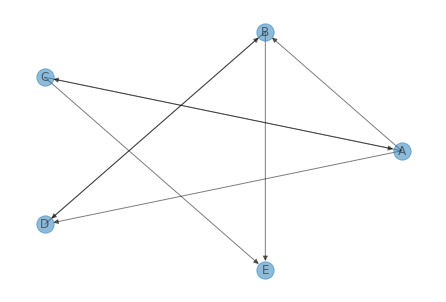

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
print("toy2 adj matrix:\n", TOY2_ADJ_MATR)



xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
latest_state_vector_of_toy2 = power_iteration(xInit, transition_matrix, 10, verbose = True) # 10
print("\nlatest_state_vector_of_toy2:\n", latest_state_vector_of_toy2)
################ (END) YOUR CODE #################

toy2 adj matrix:
 A B C D E
A 0 1 1 1 0
B 0 0 0 1 1
C 1 0 0 0 1
D 0 1 0 0 0
E 0 0 0 0 0

Step[0] Initial state:
[1. 0. 0. 0. 0.]

Step[1] state:
[0. 0.5 0. 0.5 0. ]

Step[2] state:
[0. 0. 0.25 0. 0.75]

Step[3] state:
[0.25 0.25 0.25 0.25 0. ]

Step[4] state:
[0. 0.125 0.125 0.375 0.375]

Step[5] state:
[0.125 0.125 0.1875 0.125 0.4375]

Step[6] state:
[0.14583333 0.20833333 0.20833333 0.25 0.1875 ]

Step[7] state:
[0.0625 0.13541667 0.16666667 0.28125 0.35416667]

Step[8] state:
[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]

Step[9] state:
[0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]

Step[10] state:
[0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]

latest_state_vector_of_toy2:
 [0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[29]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/5d74113d-bae1-4f39-81a1-b158b698ea13/', name='5d74113d-bae1-4f39-81a1-b158b698ea13/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[34]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[35]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[36]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
* __a)__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]
> * The raw data is a list of string. 

* __b)__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.
> * The number of records is not the same as number of nodes in the graph. THe reason is that each record in the list represent a node and its out-ward neighbors. If say a node has no outgonging edges, then this node will not be represented a record in the list. Yet, this node might the incoming edges. 

* __d)__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]
> * Dangling node (nodes that has not out-going edges)
> * num_node_nodes - num_of_records = #TODO

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def parse_line(line):
      print("line:", line)
      start_node, neighbors = line.split("\t")
      yield(start_node, 1)
      
      neighbors = eval(neighbors)
      for key in neighbors.keys():
          yield(key, 1)
    
    nodesRDD = dataRDD.map(parse_line)
#           .reduceByKey(lambda x, y: (x))
    
    totalCount = nodesRDD.collect().count()
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-3608681281198486> in <module> 
 1 # part c - run your counting job on the test file (RUN THIS CELL AS IS) 
 2 start = time . time ( ) 
 ----> 3 tot = count_nodes ( testRDD ) 
 4 print ( f'... completed job in {time.time() - start} seconds.' ) 
 5 print ( f'Total Nodes: {tot}' ) 

 <command-3608681281198485> in count_nodes (dataRDD) 
 18 # .reduceByKey(lambda x, y: (x)) 
 19 
 ---> 20 totalCount = nodesRDD . collect ( ) . count ( ) 
 21 ############## (END) YOUR CODE ############### 
 22 return totalCount

 /databricks/spark/python/pyspark/rdd.py in collect (self) 
 901 # Default path used in OSS Spark / for non-credential passthrough clusters: 
 902 with SCCallSiteSync ( self . context ) as css : 
 --> 903 sock_info = self . ctx . _jvm . PythonRDD . collectAndServe ( self . _jrdd . rdd ( ) ) 
 904 return list ( _load_from_socket ( sock_info , self . _jrdd_deserializer ) ) 
 905 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 125 def deco ( * a , ** kw ) : 
 126 try : 
 --> 127 return f ( * a , ** kw ) 
 128 except py4j . protocol . Py4JJavaError as e : 
 129 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 142.0 failed 4 times, most recent failure: Lost task 0.3 in stage 142.0 (TID 827, 10.99.251.42, executor 3): org.apache.spark.api.python.PythonException: 'TypeError: can't pickle generator objects'. Full traceback below:
Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 676, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 668, in process
 serializer.dump_stream(out_iter, outfile)
 File "/databricks/spark/python/pyspark/serializers.py", line 283, in dump_stream
 bytes = self.serializer.dumps(vs)
 File "/databricks/spark/python/pyspark/serializers.py", line 477, in dumps
 return pickle.dumps(obj, pickle_protocol)
TypeError: can't pickle generator objects

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:628)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:780)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:581)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.T

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ In the context of the PageRank algorithm, how is information about a node's out degree used?
> * #TODO

> __c1)__: What does it mean if a node's out-degree is 0? 
- If a node's out-degree is 0, it means that this node is a dangling node. You cannot go to any other node from this node.

> __c2)__:: In PageRank how will we handle these nodes differently than others?
- In PageRank, we redistribute the weight of these dangling nodes evenly across all the nodes. 
- The formula is $\frac_{m}{|G|}$, where m is the weight of the dangling nodes, and $|G|$ is the number of all of the nodes.
- Whereas non-dangling nodes (just like what they should do previously), uniformly distribute its weight arcoss all of its out-going nodes.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############

    
    
    
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain. why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)
> * In the example of web-server, N is the number of websites.
> * The probabilistic interprestation of this choice is that we have an equal chance of start surfing at any of the webpage. 
> * In fact, no matter which website we start to web-serve, say if we do inifinte randome web-serve, eventually the probability that we land at each website will converge to a steady state if the graph is a "well-behaved" graph (an irreducilbe and aperiodic).
> * Converge to a steady state means that $x_{i+1} = x_{i}P$, which means that the result of your i+1 iteration will be the same as your $i_{th}$ iteration.

> __b)__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.
> * It will be more efficient to compute \\(N\\) before initializing records for each dangling node.
> * The reason is we will need to know the total number of nodes because we need to redistribute the weights of the dangling nodes uniformly across all the nodes at the 2nd Map Job of each iteration.

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    
    
    
    
    
    
    
    
    
    # write your main Spark code here
    
    
    
    
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$
> * $\alpha$ means the probability of randomly go to a randomly webpage in the world form teh current webpage regardless of the hyperlinks exist in the current page. 
> * $|G|$ means the number of webpages in the world.
> * Together $\alpha * \frac{1}{|G|}$ means the the probability of randomly going from the current webpage to any random webpage (include the current webpage) in the world when surfer choose to just go randomly instead of clicking a hyperlink of the current webpage.

> __b)__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?
> * $m$ represent missing PageRank mass of the webpage that do NOT have a hyperlink.
> * We divide $m$ by $|G|$ because we want to evenly distribute that mass of all webpages in the graph.
> * Intuitively it means that when we encounter a dangling webpage, instead of stuck at that webpage, user can type in a random interenet address and go to any website (include the current website) from the current place.

> __c)__ How much should the total mass be after each iteration?
> * The total mass after each iteration should be 1.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.


            
    
    
    
    
    
    
    
    
    
    
    
    
    
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace

    
    
    
    
    
    
    
    
    
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform